<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/autodecoder/denoising_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:
- Construct an autoencoder in PyTorch.
- Remove noise from images.

In [37]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [38]:
# import dataset:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
print(data.shape)

# don't need labels, just extract data:
data   = data[:,1:]

# normalize the data to [0 1]:
dataNorm = data / np.max(data)

# np array -> torch tensor:
dataT = torch.tensor( dataNorm ).float()

(20000, 785)


In [39]:
def createTheMNISTAE():

  # create a class for the model:
  class aenet(nn.Module): # ae: autoencoder
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,250)

      ### encoder layer
      self.enc = nn.Linear(250,50)

      ### latent layer
      self.lat = nn.Linear(50,250)

      ### decoder layer
      self.dec = nn.Linear(250,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) ) # get the outputs in the same range as the normalized inputs
      return y

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss() # MSE loss func for continuous data

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [40]:
# test the model with a bit of data:

net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:] # first 5 entries as inputs
print(X.shape)

yHat = net(X) # outputs
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


👆 matching shape (output shape == input shape)

In [41]:
# scratch:
X[0,:].view(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

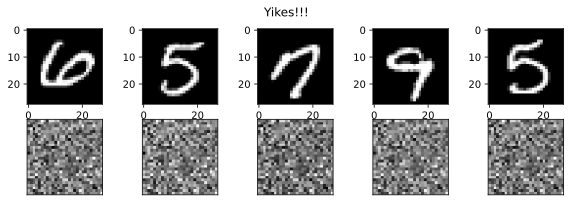

In [42]:
# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5): # choose the first 5 entries in input matrix X and output yHat
  # return a view tensor, with the same data as its base tensor but of a different shape
  # remove tensor from the computational graph (any gradients that are calculated will NOT backpropagate through it)
  axs[0,i].imshow(X[i,:].view(28,28),cmap='gray') # 1st row imgs
  # axs[0,i].set_xticks([]), axs[0,i].set_yticks([]) # hide the x and y tick labels on the plot

  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray') # 2nd row imgs
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([]) # hide the x and y tick labels on the plot

plt.suptitle('Yikes!!!') # set a higher level title above all the subplots
plt.show()

👆With the untrained model, the the model actually converted all of these images into pure white noise.

In [43]:
def function2trainTheModel():

  numepochs = 10000 # large numepochs is ok, since batch size is small

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = torch.zeros(numepochs)

  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32) # randomly choose 32 entries from the 20000
    # print(type(randomidx)) # np array
    # print(randomidx) # [ 5930  19003 12521 ... 530  19693  3327]
    X = dataT[randomidx,:]

    # forward pass
    yHat = net(X)
    loss = lossfun(yHat,X) #  compare yHat with X, because we want to get the output to match the input as closely as possible

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # record loss for this epoch:
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

In [44]:
print(losses.shape)
print(losses)

torch.Size([10000])
tensor([0.2318, 0.2300, 0.2280,  ..., 0.0070, 0.0081, 0.0060])


Final loss: 0.0047


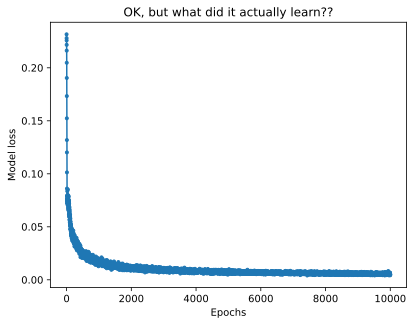

In [45]:
# train the model:
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses:
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('OK, but what did it actually learn??')
plt.show()

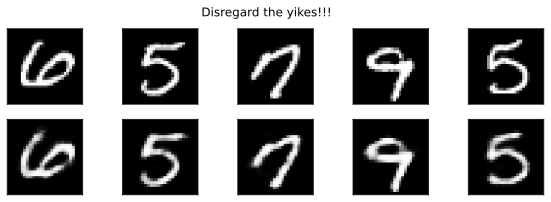

In [47]:
# grab the first 5 imgs, and repeat the visualization:
X = dataT[:5,:]
yHat = net(X)

# let's see what the model did:
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])

  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle('Disregard the yikes!!!')
plt.show()

👆When trained, the model converts those images into basically themselves, even not identical.

# Autocoder for denosing images:

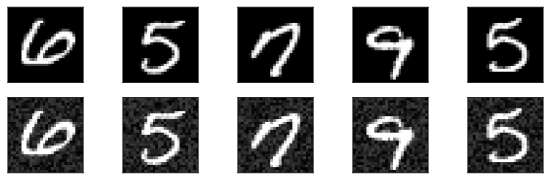

In [48]:
# grab a small set of dataT:
X = dataT[:10,:] # first 10 entries

# add some noise:
Xnoise = X + torch.rand_like(X)/4
# torch.rand_like(X) function creates a tensor of the same size as X, filled with random numbers between 0 and 1
# divide this tensor by 4 reduces all the numbers to be between 0 and 0.25.

# clip at 1:
Xnoise[Xnoise>1] = 1

# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])

  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.show()

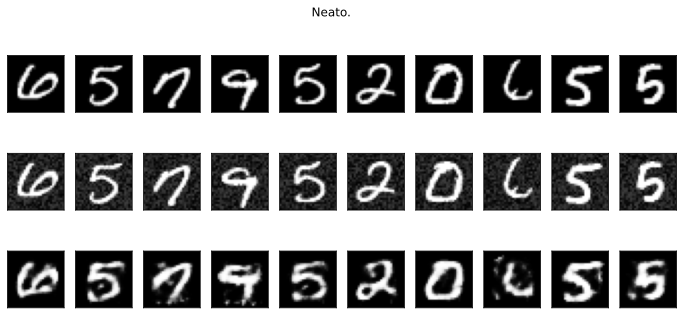

In [50]:
# now push the noisy data through the network:
Y = net(Xnoise)

# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  # 1st row: original data
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])

  # 2nd row: noisy data
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

  # 3rd row: model output with noisy data
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.suptitle('Neato.')
plt.show()

👆 Observations & conclusions:
- The autoencoder eliminated a lot of the noise, particularly the background noise from these images.
- This autoencoder does a pretty decent job of cleaning the noise, but it's certainly not perfect in the sense that it also created some distortions in the actual part of the image that we care about.
- We only have a small amount of data and we're not even training all of the images because of the way that we randomly selected images for each mini batch.
- FFN autoencoders are not as good as convolutional auto encoders. CNN autoencoders actually do better than this with fewer parameters overall.